In [5]:
import numpy as np
from MDP import *
from tqdm import tqdm
import sys

## DP Class

In [169]:
class DynamicProgramming:
    def __init__(self, MDP):
        self.R = MDP.R
        self.T = MDP.T
        self.discount = MDP.discount
        self.nStates = MDP.nStates
        self.nActions = MDP.nActions

    def helper(self, state, V):
        A = np.zeros(self.nActions)
        for action in range(self.nActions):  #take action
            for next_state in range(self.nStates):  #next state
                prob = self.T[action][state][next_state]
                reward = self.R[action][state]
                A[action] += prob * (reward + self.discount * V[next_state])  

        return A

    def valueIteration(self, initialV, nIterations=np.inf, tolerance=0.01):
        iterId = 0
        V = np.zeros(self.nStates)
        while iterId < nIterations:
            delta = 0  # ref Sutton page 205
            # Compute expected value of each action
            for state in range(self.nStates):  #current state
                # compute best action value given state
                A = self.helper(state, V)
                v = np.max(A) #max_a
                delta = max(delta, np.abs(v - V[state])) #max(delta, |v − V (s)|)
                V[state] = v # update V
            if delta < tolerance:
                break
            iterId += 1
            
        # EVAL
        policy = self.extractPolicy(V)

        return [policy, V, iterId, delta]

    def policyIteration_v1(self, initialPolicy, nIterations=np.inf, tolerance=0.01):
        policy = np.zeros([self.nActions, self.nStates])
        policy[0] = 1
        iterId = 0
        # Loop
        while True:
            print(iterId)
            # Run policy eval
            V = self.evaluatePolicy_SolvingSystemOfLinearEqs(policy)
            policy_stable = True
            # loop for each s in S
            for state in range(self.nStates):
                # Find old action
                action = np.argmax(policy[:, state])
                # New action
                action_values = self.helper(state, V)
                best_action = np.argmax(action_values)
                # If old-action 6= ⇡(s), then policy-stable false
                if action != best_action:
                    policy_stable = False
                # update policy
                policy[:, state] = np.eye(self.nActions)[best_action]

            if policy_stable:  # return policy
                print('here')
                break
            iterId += 1  # increment

        policy = np.array([np.argmax(policy[:,i]) for i in range(self.nStates)])
        return [policy, V, iterId]


    def extractPolicy(self, V):
        '''Procedure to extract a policy from a value function
        pi <-- argmax_a R^a + gamma T^a V

        Inputs:
        V -- Value function: array of |S| entries

        Output:
        policy -- Policy: array of |S| entries'''

        policy = np.zeros(self.nStates)
        for i in range(self.nStates):
            A = self.helper(i, V)
            best_action = np.argmax(A)
            policy[i] = best_action

        return policy


    def evaluatePolicy_SolvingSystemOfLinearEqs(self, policy):
        V = np.zeros((self.nStates))
        R = np.zeros((self.nStates))
        T = np.zeros((self.nStates, self.nStates))
        for state in range(mdp.nStates):
            action = np.argmax(policy[:,state])
            #scalar
            R[state] = self.R[action][state]
            T = self.T[action]
            # 17 x 17 * 
            ident = np.identity(self.nStates)
            # 17 x 17 - T
            gamme_T = self.discount * self.T[action][state]
            v = np.dot(np.linalg.inv(ident - gamme_T), self.R[action])[state]
            V[state] = v
        return V

    def policyIteration_v2(self, nPolicyEvalIterations=10, nIterations=np.inf, tolerance=0.01):
        #init policy, taking a_i = 0 in all states 
        policy = np.zeros([self.nActions, self.nStates])
        policy[0] = 1
        iterId = 0
        
        #Loop
        while True:
            #Run policy eval
            V,delta = self.evaluatePolicy_IterativeUpdate(policy, tolerance, nPolicyEvalIterations)
            policy_stable = True
            #loop for each s in S
            for state in range(mdp.nStates):
                #Find old action
                action = np.argmax(policy[:, state])
                #New action
                action_values = self.helper(state, V)
                best_action = np.argmax(action_values)     
                #If old-action 6= ⇡(s), then policy-stable false
                if action != best_action:
                    policy_stable = False
                #update policy
                policy[:,state] = np.eye(self.nActions)[best_action]

            if policy_stable: #return policy
                break
            iterId += 1 #increment
            
        policy = np.array([np.argmax(policy[:,i]) for i in range(self.nStates)])
        return [policy, V, iterId, delta]

    def evaluatePolicy_IterativeUpdate(self, policy, epsilon, nIterations):
        V = np.zeros(self.nStates)
        #loop
        for i in range(nIterations):
            #delta to 0
            delta = 0
            #Loop over s in S
            for state in range(self.nStates):
                #value to 0
                v = 0
                for action, action_prob in enumerate(policy[:, state]):
                    for next_state, prob in enumerate(self.T[action][state]):
                        v += action_prob * prob * (self.R[action][state] + self.discount * V[next_state])
                delta = max(delta, np.abs(v - V[state]))
                V[state] = v
            if delta < epsilon:
                break
        return V,delta


In [171]:
mdp = build_mazeMDP()
dp = DynamicProgramming(mdp)
[policy, V, nIterations] = dp.policyIteration_v1(
    np.zeros(dp.nStates, dtype=int))
policy
print_policy(policy)
V
# V

# policy = np.zeros([mdp.nActions, mdp.nStates])
# policy[0] = 1
# policy

# """
# 𝑅: 𝑆×1 column vector of sate rewards for 𝜋
# 𝑉: 𝑆×1 column vector of state values for 𝜋
# 𝑇: 𝑆×𝑆 matrix of transition prob for 𝜋
# """

# mdp.R

# R = np.zeros((mdp.nStates))
# V = np.zeros((mdp.nStates))

# for state in range(mdp.nStates):
#     action = np.argmax(policy[:,state])
#     #scalar
#     R[state] = mdp.R[action][state]
#     T = mdp.T[action]
#     # 17 x 17 * 
#     ident = np.identity(mdp.nStates)
#     # 17 x 17 - T
#     gamme_T = mdp.discount * mdp.T[action][state]
#     v = np.dot(np.linalg.inv(ident - gamme_T), mdp.R[action])[state]
#     V[state] = v

# np.shape(np.linalg.inv(ident - gamme_T))
# np.shape(mdp.R[action])

# a = np.linalg.inv(ident - gamme_T)
# b = mdp.R[action]
# V
policy

0
1
2
3
4
here
========= policy ==========
↑↑→↑
↑↑→↓
←←→→
←→↓↑


array([0, 0, 3, 0, 0, 0, 3, 1, 2, 2, 3, 3, 2, 3, 1, 0, 0], dtype=int64)


## Value Iteration

In [172]:
mdp = build_mazeMDP()
dp = DynamicProgramming(mdp)
[policy, V, nIterations, epsilon] = dp.valueIteration(initialV=np.zeros(dp.nStates), tolerance=0.01)
print_policy(policy)
print("========= Value Function ==========")
print(V)
print("========= Number of Iterations ==========")
print(nIterations)
print("========= Epsilon ==========")
print(epsilon)
print(policy)

========= policy ==========
→→→↓
↓→→↓
↓↓→↓
→→→↑
========= Value Function ==========
[ 52.98272805  58.65479586  71.80603574  77.09290223  46.03800916
  -5.15258579  77.83147962  84.1414826   56.78207149   1.29847647
  84.86729996  91.7816501   68.76914229  76.10763148  91.7816501
 100.           0.        ]
========= Number of Iterations ==========
15
========= Epsilon ==========
0.005867296241156339
[3. 3. 3. 1. 1. 3. 3. 1. 1. 1. 3. 1. 3. 3. 3. 0. 0.]


## Policy Iteration

In [753]:
# Test policy iteration v1
[policy, V, nIterations] = dp.policyIteration_v1(
    np.zeros(dp.nStates, dtype=int))
print_policy(policy)

here
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
here
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
========= policy ==========
↑↑←↑
←↑→↑
←↓→↓
↑↓→↑


In [213]:
logs = {}
for i in range(4,11):
    print("========================================")
    print('nPolicyEvalIterations: ', i)
    print("========================================")
    [policy, V, nIterations, epsilon] = dp.policyIteration_v2(nPolicyEvalIterations = i,tolerance=0.01)
    print_policy(policy)
#     print("========= Value Function ==========")
#     print(V)
    print("Number of Iterations", nIterations)
    print("Epsilon", epsilon)
    logs[i] = (nIterations, epsilon)
    
import pandas as pd
df = pd.DataFrame.from_dict(logs).T.reset_index()
df.columns = ['policyEvalIterations', 'main_iterations', 'epsilon']
df.plot(x = 'policyEvalIterations', y = 'epsilon')
df.plot(x = 'policyEvalIterations', y = 'main_iterations')

nPolicyEvalIterations:  4
========= policy ==========
↑↑↓↓
←→→↓
↓→→↓
→→→↑
Number of Iterations 4
Epsilon 54.53783332501359
nPolicyEvalIterations:  5
========= policy ==========
↑→→↓
↓→→↓
↓→→↓
→→→↑
Number of Iterations 4
Epsilon 42.86054598324621
nPolicyEvalIterations:  6
========= policy ==========
→→→↓
↓→→↓
↓→→↓
→→→↑
Number of Iterations 4
Epsilon 32.6027457778596
nPolicyEvalIterations:  7
========= policy ==========
→→→↓
↓→→↓
↓→→↓
→→→↑
Number of Iterations 4
Epsilon 27.75165627477627
nPolicyEvalIterations:  8
========= policy ==========
→→→↓
↓→→↓
↓↓→↓
→→→↑
Number of Iterations 3
Epsilon 21.953518689778832
nPolicyEvalIterations:  9
========= policy ==========
→→→↓
↓→→↓
↓↓→↓
→→→↑
Number of Iterations 3
Epsilon 10.887787272982386
nPolicyEvalIterations:  10
========= policy ==========
→→→↓
↓→→↓
↓↓→↓
→→→↑
Number of Iterations 3
Epsilon 4.399169365305696


NameError: name 'pd' is not defined

## RL Class

In [715]:
class ReinforcementLearning:
    def __init__(self, mdp, sampleReward):
        """
        Constructor for the RL class

        :param mdp: Markov decision process (T, R, discount)
        :param sampleReward: Function to sample rewards (e.g., bernoulli, Gaussian). This function takes one argument:
        the mean of the distribution and returns a sample from the distribution.
        """

        self.mdp = mdp
        self.sampleReward = sampleReward

    def sampleRewardAndNextState(self, state, action):
        '''Procedure to sample a reward and the next state
        reward ~ Pr(r)
        nextState ~ Pr(s'|s,a)

        Inputs:
        state -- current state
        action -- action to be executed

        Outputs:
        reward -- sampled reward
        nextState -- sampled next state
        '''

        reward = self.sampleReward(self.mdp.R[action, state])
        cumProb = np.cumsum(self.mdp.T[action, state, :])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward, nextState]

    def OffPolicyTD(self, nEpisodes, epsilon=0.5):

        stats = {}
        Q = np.zeros([self.mdp.nActions, self.mdp.nStates])
        policy = np.zeros(self.mdp.nStates, int)

        for i_episode in range(1, nEpisodes + 1):
            rewards, episode_length, state = 0, 0, 0
            done = False

            while not done:
                choice = np.random.choice([0, 1], p=[epsilon, 1-epsilon])
                if choice == 0:
                    action = np.random.choice(self.mdp.nActions)
                else:
                    action = policy[state]

                reward, next_state = self.sampleRewardAndNextState(
                    state, action)

                best_next = np.argmax(Q[:, next_state])
                td_target = reward + self.mdp.discount * \
                    Q[best_next][next_state]
                td_delta = td_target - Q[action][state]
                Q[action][state] += 0.5 * td_delta

                for i in range(self.mdp.nStates):
                    policy[i] = np.argmax(Q[:, i])

                if self.mdp.isTerminal(state):
                    stats[i_episode] = (rewards, episode_length)
                    break
                else:
                    state = next_state
                    rewards += reward
                    episode_length += 1

        return [Q, policy, stats]

    def e_soft(self, epsilon, Q):
        def policy(state):
            a = np.ones(self.mdp.nActions) * epsilon / self.mdp.nActions
            best_action = np.argmax(Q[state, :])
            a[best_action] = 1 - ((self.mdp.nActions - 1) * epsilon / self.mdp.nActions)
            return a
        return policy
        

    def OffPolicyMC(self, nEpisodes, epsilon=0.0):
        stats = {}
        Q = np.zeros([self.mdp.nStates, self.mdp.nActions])
        C = np.zeros([self.mdp.nStates, self.mdp.nActions])
        b = self.e_soft(epsilon, Q)
        
        for i_episode in range(1, nEpisodes + 1):
            if i_episode % 1000 == 0:
                print(f"Episode {i_episode}/{nEpisodes}")
            
            # Behavioral Policy
            # Generate an episode using b: S0,A0,R1, . . . ,ST−1,AT−1,RT
            episode = []
            rewards, episode_length, state = 0, 0, 0 
            state = 0
            while True:
                probs = b(state)
                action = np.random.choice(np.arange(len(probs)), p=probs)
                reward, next_state = self.sampleRewardAndNextState(
                    state, action)
                
                episode.append((state, action, reward))

                if self.mdp.isTerminal(state):
                    break
                state = next_state
                rewards += reward
                episode_length += 1
                
            stats[i_episode] = (rewards, episode_length)
            
            G = 0
            W = 1
            # Loop for each step of episode, t = T −1, T −2, . . . , 0:
            for idx, step in enumerate(episode[::-1]):
                #extract SAR
                state, action, reward = step
                
                #G = gamma * G + Rt+1
                G = self.mdp.discount * G + reward
                
                #C(St,At) <- C(St,At) +W
                C[state][action] += W
                
                #Q(St,At) <-  Q(St,At) + W/C(St,At) [G − Q(St,At)]
                Q[state][action] += (W / C[state][action]) * \
                                    (G - Q[state][action])
                
                if action != np.argmax(Q[state,:]):
                    break
                W = W * (1 / b(state)[action])
        
        policy = np.array([np.argmax(Q[i,:]) for i in range(self.mdp.nStates)])    
        return [Q, policy, stats]

In [716]:
mdp = build_mazeMDP()
rl = ReinforcementLearning(mdp, np.random.normal)

Episode 1000/5000
Episode 2000/5000
Episode 3000/5000
Episode 4000/5000
Episode 5000/5000
========= policy ==========
→→↓↓
↑→→↓
←→→↓
↑↑→↑


## Q Learning Evaluation

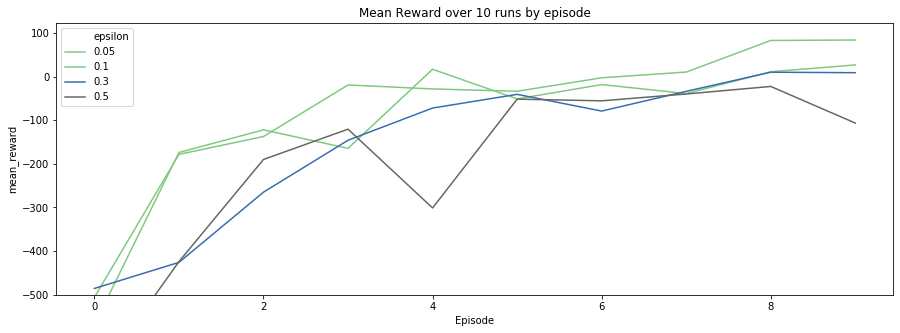

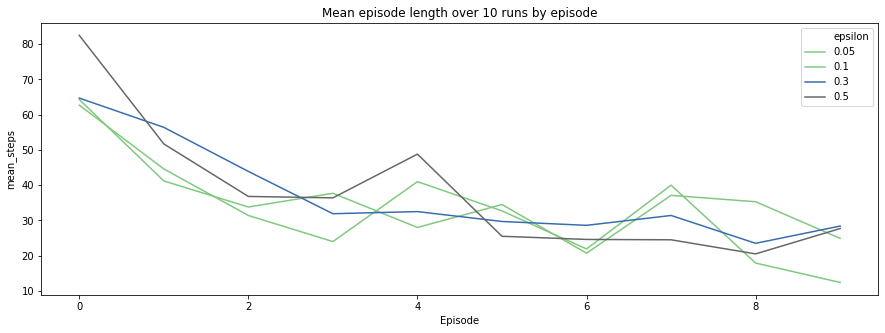

In [140]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

df = pd.DataFrame()
num_runs = 10
num_episodes = 10

for epsilon in [0.05, 0.1, 0.3, 0.5]:
    cum_reward = np.zeros(num_episodes)
    cum_steps = np.zeros(num_episodes)
    for run in range(num_runs):
        [Q, policy, stats] = rl.OffPolicyTD(num_episodes, epsilon)
        cum_reward += [i[0] for i in stats.values()]
        cum_steps += [i[1] for i in stats.values()]
    cum_reward /= num_runs
    cum_steps /= num_runs
    
    temp = pd.DataFrame()
    temp['mean_reward'] = cum_reward
    temp['mean_steps'] = cum_steps
    temp['epsilon'] = epsilon
    df = df.append(temp)

    
sns.lineplot(x = df.index, y = df['mean_reward'], hue= df['epsilon'], palette= 'Accent', legend = 'full')
plt.xlabel('Episode')
plt.title(f'Mean Reward over {num_runs} runs by episode')
plt.ylim(-500)
plt.show()

sns.lineplot(x = df.index, y = df['mean_steps'], hue= df['epsilon'], palette= 'Accent', legend = 'full')
plt.xlabel('Episode')
plt.title(f'Mean episode length over {num_runs} runs by episode')
plt.show()

## MC Sampling Evaluation

In [720]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

mdp = build_mazeMDP()
rl = ReinforcementLearning(mdp, np.random.normal)
df = pd.DataFrame()
num_runs = 10
num_episodes = 5000

cum_reward = np.zeros(num_episodes)
cum_steps = np.zeros(num_episodes)

dfs = pd.DataFrame()
for run in range(num_runs):
    [Q, policy, stats] = rl.OffPolicyMC(nEpisodes=num_episodes, epsilon=0.1) 
    df = pd.DataFrame.from_dict(stats).T
    dfs = dfs.append(df)


Episode 1000/5000
Episode 2000/5000
Episode 3000/5000
Episode 4000/5000
Episode 5000/5000
Episode 1000/5000
Episode 2000/5000
Episode 3000/5000
Episode 4000/5000
Episode 5000/5000
Episode 1000/5000
Episode 2000/5000
Episode 3000/5000
Episode 4000/5000
Episode 5000/5000
Episode 1000/5000
Episode 2000/5000
Episode 3000/5000
Episode 4000/5000
Episode 5000/5000
Episode 1000/5000
Episode 2000/5000
Episode 3000/5000
Episode 4000/5000
Episode 5000/5000
Episode 1000/5000
Episode 2000/5000
Episode 3000/5000
Episode 4000/5000
Episode 5000/5000
Episode 1000/5000
Episode 2000/5000
Episode 3000/5000
Episode 4000/5000
Episode 5000/5000
Episode 1000/5000
Episode 2000/5000
Episode 3000/5000
Episode 4000/5000
Episode 5000/5000
Episode 1000/5000
Episode 2000/5000
Episode 3000/5000
Episode 4000/5000
Episode 5000/5000
Episode 1000/5000
Episode 2000/5000
Episode 3000/5000
Episode 4000/5000
Episode 5000/5000


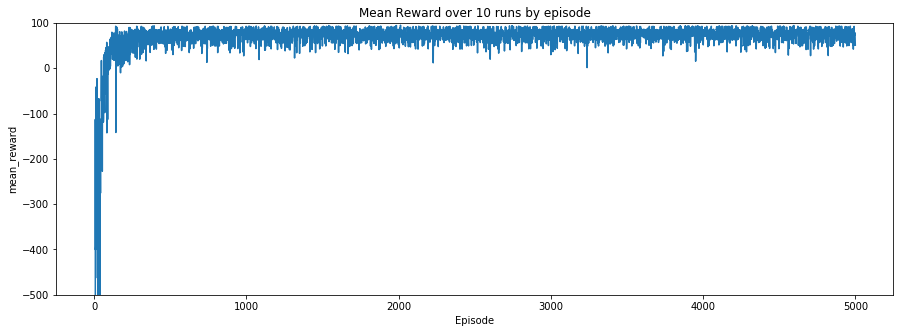

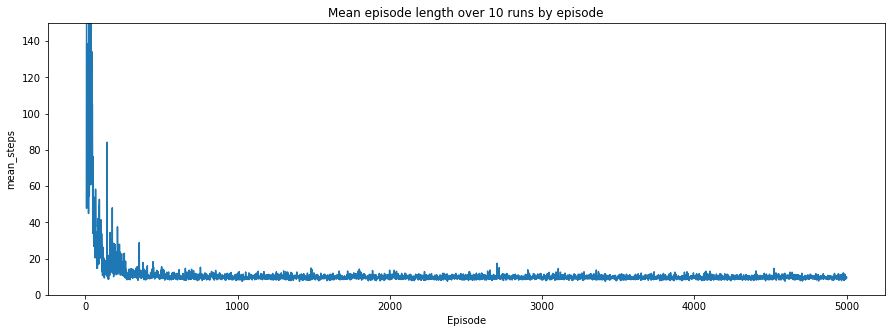

In [721]:
dfs = dfs.reset_index()
dfs = dfs.groupby('index').mean().reset_index()
dfs.columns = ['episode', 'mean_reward', 'mean_steps']

    
sns.lineplot(x = dfs['episode'], y = dfs['mean_reward'])
plt.xlabel('Episode')
plt.title(f'Mean Reward over {num_runs} runs by episode')
plt.ylim(-500,100)
plt.show()

sns.lineplot(x = dfs['episode'], y = dfs['mean_steps'])
plt.xlabel('Episode')
plt.title(f'Mean episode length over {num_runs} runs by episode')
plt.ylim(0,150)

plt.show()

In [ ]:
ss